# Collection of Functions within notebook to then port to specific .py files

Useful reference: http://mathesaurus.sourceforge.net/idl-numpy.html


## APOD3D Helping function

In [1]:
import numpy as np


def do_apod3d(nx, ny, nz):
    '''
    Construct a 3D dimensional apodisation function

    Parameters
    ----------
        Dimensions of required cube
        nx - int
        ny - int
        nz - int

    '''

    apodx = np.sin(np.pi*(np.arange(0, nx, 1, dtype=float)+0.5)/nx) ** 2
    apody = np.sin(np.pi*(np.arange(0, ny, 1, dtype=float)+0.5)/ny) ** 2
    apodz = np.sin(np.pi*(np.arange(0, nz, 1, dtype=float)+0.5)/nz) ** 2

    apodxy = np.matmul(apodx[:, np.newaxis], apody[np.newaxis, :])
    apodxyz = np.matmul(apodxy[:, :, np.newaxis], apodz[np.newaxis, :])

    return apodxyz


# basic unit test to see if apodisation is working
apod = do_apod3d(20, 20, 20)
assert apod.shape == (20, 20, 20), 'Dimensions incorrect'

NameError: name 'test' is not defined

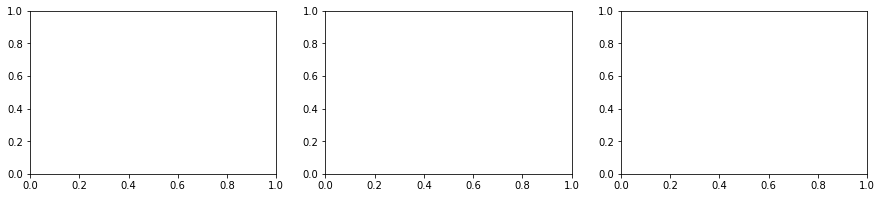

In [2]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
_ = ax[0].plot(test[:,20,20])
_ = ax[1].plot(test[20,:,20])
_ = ax[2].plot(test[20,20,:])

## noise_gate

In [3]:
# Performs noise-gating of images


# INPUT - data cube

# OUTPUT - noise-gated data cube

# OPTIONAL INPUTS - gate - use gating (default is Weiner Filter)
#                   dct - use Discrete Fourier Transform (much slower)
#                   perc - percentage level of samples to calculate noise level, default 0.5 (median)
#                   gamma - level of SNR to use as a cut-off value, default is 1.5
#                   image_indepen_noise - calculation for removal of image independent additive noise
# TO DO - Parallelise -> WHERE?

import numpy as np
from itertools import product

In [53]:
# Recommend using "Utils" Object to hold all relevant functions / image information


class ImageCube:
    def __init__(self, image, fourier_image):
        self.image = image
        self.fourier_image = fourier_image

    def _estimate_shot_noise(self):
        fac = np.sum(np.sqrt(self.image[self.image > 0]))
        betas = np.abs(self.fourier_image)/fac
        self.betas = betas
        return betas

    def _image_indepen_noise(self):
        betas = np.abs(self.fourier_image)
        self.betas = betas
        return betas

    def gate_filter(self, beta, gamma=1.5):
        fourier_amp = np.abs(self.fourier_image)
        threshold = gamma * beta
        filt = np.logical_not(fourier_amp < threshold)
        return filt

    def wiener_filter(self, beta, gamma=1.5):
        filt = np.abs(self.fourier_image) / \
            (gamma*beta+np.abs(self.fourier_image))
        return filt

In [11]:
# def noise_gate(data, win_size=12, perc=0.5, beta_const=False,
#               image_indepen_noise=False, gate=True)


def calc_noise_profile(data, win_size=12, perc=50, beta_const=False,
                       image_indepen_noise=False, gate=True):
    """
    Noise-gate a data cube.

    :param data: Data cube - expects order (x, y, t)
    :param perc: percentage value for noise estimate, default 50% (median)
    :param beta_const: Select for single value of beta across fourier space
    :param image_indepen_noise: Select for calculation of image independent noise
    """
    nx, ny, nz = data.shape

    half_win = win_size // 2

    # Apodisation cube for sub-images
    apod = do_apod3d(win_size, win_size, win_size)

    # Loop for calculating noise profile -> Is this what can be parallelised?
    # No, this is quite quick

    print("Calculating noise model...")

    strides_x = np.arange(half_win, nx, step=win_size)
    strides_y = np.arange(half_win, ny, step=win_size)

    noise_elem = len(strides_x)*len(strides_y)

    # Scratch array
    noise_arr = np.zeros(
        shape=(win_size, win_size, win_size, noise_elem), dtype='float64')

    # get estimates for noise from multiple sub-images
    fft = np.fft.fftn
    for count, (i, j) in enumerate(product(strides_x, strides_y)):

        # define sub-image coordinates
        x = (int(i-half_win), int(i+half_win))
        y = (int(j-half_win), int(j+half_win))

        # move on if coordinates out of bounds
        if y[1] > ny or x[1] > nx:
            continue

        # define sub-image and apodise
        sub_image = data[x[0]:x[1], y[0]:y[1], 0:win_size] * apod
        fourier_image = fft(sub_image)

        subImageCube = ImageCube(sub_image, fourier_image)

        if image_indepen_noise:
            subImageCube._image_indepen_noise()
        else:
            subImageCube._estimate_shot_noise()

        noise_arr[:, :, :, count] = subImageCube.betas

    # Calculate noise profile
    if beta_const:
        betas = np.percentile(noise_arr.ravel(), perc)
    else:
        betas = np.percentile(noise_arr, perc, axis=3)

    return betas


# if __name__ == '__main__':

#    data_cube = np.random.rand(100, 100, 100)

#    noise_arr = noise_gate(data=data_cube)

In [43]:
def filter_loop(data, betas, apod=apod, win_size=12, beta_const=False,
                image_indepen_noise=False, gate=False):

    nx, ny, nz = data.shape

    half_win = win_size // 2


def run_filter(data, betas, win_size=12, beta_const=False,
               image_indepen_noise=False, gate=False):

    nx, ny, nz = data.shape
    half_win = win_size // 2

    # Apodisation cube for sub-images
    apod = do_apod3d(win_size, win_size, win_size)
    
        # short-hand for fft functions
    fft = np.fft.fftn
    ifft = np.fft.ifftn
    fftshift = np.fft.fftshift

    over_sample_width = win_size/4  # using sin**4 window  

    strides_x = np.arange(half_win, nx-half_win, step=over_sample_width)
    strides_y = np.arange(half_win, ny-half_win, step=over_sample_width)
    strides_z = np.arange(half_win, nz-half_win, step=over_sample_width)
    
    n_calc = len(strides_x)*len(strides_y)*len(strides_z)

    print('Implementing noise gating...')
    gated_data = np.zeros(shape=(nx, ny, nz), dtype='float64')  # scratch array
    for count, (i, j, k) in enumerate(product(strides_x, strides_y, strides_z)):

        # define sub-image coordinates
        x = (int(i-half_win), int(i+half_win))
        y = (int(j-half_win), int(j+half_win))
        z = (int(k-half_win), int(k+half_win))

        if y[1] > ny or x[1] > nx or z[1] > nz:
            continue

        sub_image = data[x[0]:x[1], y[0]:y[1], z[0]:z[1]] * apod
        fourier_image = fft(sub_image)

        subImageCube = ImageCube(sub_image, fourier_image)

        if image_indepen_noise:
            noise_profile = betas
        else:
            im_clip = np.copy(sub_image)
            im_clip[im_clip < 0] = 0
            im_total = np.sum(np.sqrt(im_clip))
            noise_profile = betas*im_total

        if gate:
            filt = subImageCube.gate_filter(noise_profile)
        else:
            filt = subImageCube.wiener_filter(noise_profile)

        # Keeping core region of DFT when using varying beta
        if not beta_const:
            core = (half_win-1, half_win+2)
            filt = fftshift(filt)

            filt[core[0]:core[1],
                 core[0]:core[1],
                 core[0]:core[1]] = 1

            filt = fftshift(filt)

        inverse_ft = (ifft(fourier_image*filt)*apod).real
        gated_data[x[0]:x[1], y[0]:y[1], z[0]:z[1]] += inverse_ft
        
        print('{:3.1f} % complete'.format(100*count/n_calc), end="\r")
        
    # correction factor for windowing
    # only applicable for sin^4 window
    gated_data /= (1.5)**3

    return gated_data

In [7]:
from scipy.io.idl import readsav
from os.path import expanduser

home = expanduser('~')
filepath = home + '/github_reps/noise_gating/cut_out.idlsav'
data = readsav(filepath)

In [8]:
images = data['cut_out']
images = np.transpose(images, [1,2,0])
images = images.astype('float64')
images.shape

(601, 1025, 52)

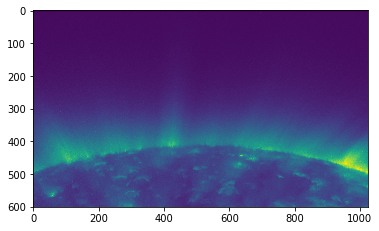

In [9]:
plt.imshow(images[:,:,0])

In [12]:
test = np.copy(images[300:600,0:200,:])


betas = calc_noise_profile(test)

Calculating noise model...


In [34]:
%load_ext line_profiler
%lprun -s -f run_filter -T lp_results.txt run_filter(test, betas)

Implementing noise gating...


TypeError: 'numpy.ndarray' object is not callable

In [54]:
gated_data = run_filter(test, betas, gate=True)

Implementing noise gating...


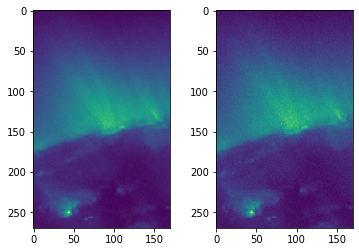

In [55]:
fig, ax = plt.subplots(1,2)

original  = images[300+15:600-15,15:200-15,15]
gated = gated_data[15:-15,15:-15,15]
ax[0].imshow(gated)
ax[1].imshow(original)

In [56]:
print(np.max(gated), np.min(gated))

836.7865868329478 98.32635303851372


In [40]:
print(np.max(original), np.min(original))

835.0 86.0


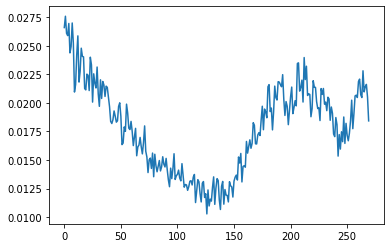

In [57]:
sub_tr = original-gated

mn_gate = gated.mean(axis=1)
plt.plot((np.abs(sub_tr)).mean(axis=1)/mn_gate)

0.1051292529324011 -0.18957938204529404


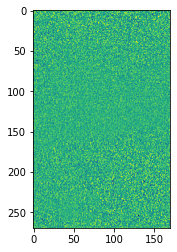

In [58]:
# noise image
plt.imshow(sub_tr/original)
print(np.max(sub_tr/original), np.min(sub_tr/original))

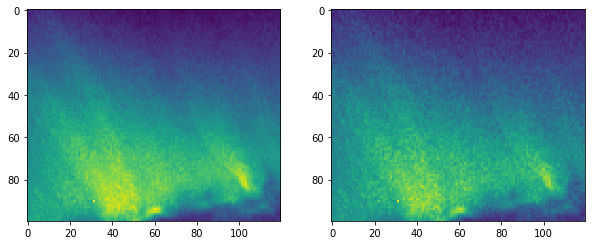

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(gated[50:150,50:200])
ax[1].imshow(original[50:150,50:200])